This is a data analysis of scrapedRussia Today News headlines in German. 

The analysis only includes headlines from the year 2020.






In [58]:
import pandas as pd
import numpy as np
import collections
import spacy
import nltk
from math import sqrt
import glob
import re
from collections import Counter, OrderedDict
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import datetime as dt
import matplotlib.dates as mdate
from spacy_sentiws import spaCySentiWS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# stop words
german_stop_words = stopwords.words('german')

# German lemmatizer
nlp = spacy.load(r'<path to de_core_news_sm/de_core_news_sm-2.3.0>')

# sentiment analysis lexicon
nlp2 = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path=r'<path to spacy_sentiws/data>')
nlp2.add_pipe(sentiws)

# pandas options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [59]:
# merge scraped info in csv-files to pandas df
path = r'<path to EDA_RT_Headlines>'
all_files = glob.glob(path + "/*.csv")

# make list do store all dfs
csv_list = []

# concatenate to one df
df_from_each_file = (pd.read_csv(f) for f in all_files)
df= pd.concat(df_from_each_file, ignore_index=True)

# drop duplicate headlines
df = df.drop_duplicates(subset='Headline', keep="first")


In [60]:
df

,Headline,Date,category
0,\n\t Ukrainischer Kleriker warnt vo...,\n\t\t\t28.09.2020 06:45 Uhr\n\t\t,gesellschaft
1,\n\t Der Magnet-Künstler: Kleben un...,\n\t\t\t27.09.2020 19:55 Uhr\n\t\t,gesellschaft
2,"\n\t Es grünt: Guccis ""Gärtner-Jean...",\n\t\t\t26.09.2020 16:55 Uhr\n\t\t,gesellschaft
3,\n\t Chef des Weltwirtschaftsforums...,\n\t\t\t26.09.2020 16:20 Uhr\n\t\t,gesellschaft
4,\n\t Umstrittene Maßnahme: Absichtl...,\n\t\t\t26.09.2020 09:41 Uhr\n\t\t,gesellschaft
...,...,...,...
9289,"\n\t Joseph Stiglitz: ""Europa muss ...",\n\t\t\t14.10.2017 07:30 Uhr\n\t\t,wirtschaft
9290,\n\t Deutsche Wirtschaft: Isolation...,\n\t\t\t13.10.2017 19:57 Uhr\n\t\t,wirtschaft
9291,\n\t Auf Kosten Athens: EU-Zentralb...,\n\t\t\t13.10.2017 12:12 Uhr\n\t\t,wirtschaft
9292,\n\t IWF: Steuergeschenke für Reich...,\n\t\t\t13.10.2017 06:30 Uhr\n\t\t,wirtschaft


In [61]:
# DataCleaner class: removes whitespace, converts to datetime, removes punctuation, counts words

class DataCleaner:
    def __init__(self, df_column):
        self.df_column = df_column

    def remove_whitespace(self):
        column_stripped = self.df_column.strip()
        return column_stripped
    
    def date_time(self):
        date_time = self.df_column.replace(' Uhr', "")
        date_time = pd.to_datetime(date_time, format='%d.%m.%Y %H:%M')
        return date_time
    
    def remove_punct(self):
        
        # remove everything that is not whitespace or word character
        no_punct = re.sub(r'[^\w\s]','',self.df_column) 
        return no_punct
        
    def get_word_count(self):
        
        # count how many words are in each headline
        word_count = len(self.df_column.split())
        return word_count
        
        
        


In [62]:
# remove whitespace
df['Headline'] = df['Headline'].apply(lambda row: DataCleaner(row).remove_whitespace())
df['Date'] = df['Date'].apply(lambda row: DataCleaner(row).remove_whitespace())

#convert to datetime
df['Date'] = df['Date'].apply(lambda row: DataCleaner(row).date_time())

# remove punctuation
df['Headline'] = df['Headline'].apply(lambda row: DataCleaner(row).remove_punct())

# count words
df['Word Count'] = df['Headline'].apply(lambda row: DataCleaner(row).get_word_count())


In [63]:
df


,Headline,Date,category,Word Count
0,Ukrainischer Kleriker warnt vor den Schweinere...,2020-09-28 06:45:00,gesellschaft,8
1,Der MagnetKünstler Kleben und kleben lassen Video,2020-09-27 19:55:00,gesellschaft,7
2,Es grünt Guccis GärtnerJeans mit Grasflecken f...,2020-09-26 16:55:00,gesellschaft,15
3,Chef des Weltwirtschaftsforums Neoliberalismus...,2020-09-26 16:20:00,gesellschaft,8
4,Umstrittene Maßnahme Absichtliche CoronaInfekt...,2020-09-26 09:41:00,gesellschaft,9
...,...,...,...,...
9289,Joseph Stiglitz Europa muss enger zusammenrücken,2017-10-14 07:30:00,wirtschaft,6
9290,Deutsche Wirtschaft Isolation des Iran birgt g...,2017-10-13 19:57:00,wirtschaft,12
9291,Auf Kosten Athens EUZentralbank verdiente rund...,2017-10-13 12:12:00,wirtschaft,11
9292,IWF Steuergeschenke für Reiche untergraben Wac...,2017-10-13 06:30:00,wirtschaft,6


In [64]:
# filter by year
df_2020 = df[df['Date'].dt.year == 2020]

In [65]:
# class PrepareText splits text into tokens, lemmas, and removes stopwords, and creates bow

class PrepareText:
    def __init__(self, df_column):
        self.df_column = df_column
        
    def remove_stopwords(self):
        token = self.df_column.split(' ')
        no_stopwords = [word for word in token if word.lower() not in german_stop_words]
        
        # remove "video"
        remove_word = [word for word in no_stopwords if word != 'Video']
        
        # remove whitespace
        no_stopwords = [word for word in remove_word if word]
        

        return no_stopwords
        
    def get_lemmas(self):
        
        lemmas_list = []
        
        for sentence in self.df_column:
            doc = nlp(sentence)
            for token in doc:
                lemmas_list.append(token.lemma_)
        return lemmas_list
    
    def get_bow(self):
        
        lemmas = self.df_column
        
        # Bow: counts word occurences, and 
        # returns ordered dictionary beginning with the most common
        bow = OrderedDict(Counter(lemmas).most_common())
        return bow       

In [66]:
# apply row-wise
df_2020['Article: No Stopwords'] = df_2020['Headline'].apply(lambda row: PrepareText(row).remove_stopwords())
df_2020['Lemmas'] = df_2020['Article: No Stopwords'].apply(lambda row: PrepareText(row).get_lemmas())
df_2020['BoW'] = df_2020['Lemmas'].apply(lambda row: PrepareText(row).get_bow())

<ipython-input-66-e6ac5ac6278b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['Article: No Stopwords'] = df_2020['Headline'].apply(lambda row: PrepareText(row).remove_stopwords())
<ipython-input-66-e6ac5ac6278b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['Lemmas'] = df_2020['Article: No Stopwords'].apply(lambda row: PrepareText(row).get_lemmas())
<ipython-input-66-e6ac5ac6278b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [67]:
df_2020

,Headline,Date,category,Word Count,Article: No Stopwords,Lemmas,BoW
0,Ukrainischer Kleriker warnt vor den Schweinere...,2020-09-28 06:45:00,gesellschaft,8,"[Ukrainischer, Kleriker, warnt, Schweinereien,...","[Ukrainischer, Kleriker, warnen, Schweinerei, ...","{'Ukrainischer': 1, 'Kleriker': 1, 'warnen': 1..."
1,Der MagnetKünstler Kleben und kleben lassen Video,2020-09-27 19:55:00,gesellschaft,7,"[MagnetKünstler, Kleben, kleben, lassen]","[MagnetKünstler, Kleben, kleben, lassen]","{'MagnetKünstler': 1, 'Kleben': 1, 'kleben': 1..."
2,Es grünt Guccis GärtnerJeans mit Grasflecken f...,2020-09-26 16:55:00,gesellschaft,15,"[grünt, Guccis, GärtnerJeans, Grasflecken, kna...","[grünt, Guccis, GärtnerJeans, Grasflecken, kna...","{'grünt': 1, 'Guccis': 1, 'GärtnerJeans': 1, '..."
3,Chef des Weltwirtschaftsforums Neoliberalismus...,2020-09-26 16:20:00,gesellschaft,8,"[Chef, Weltwirtschaftsforums, Neoliberalismus,...","[Chef, Weltwirtschaftsforums, Neoliberalismus,...","{'Chef': 1, 'Weltwirtschaftsforums': 1, 'Neoli..."
4,Umstrittene Maßnahme Absichtliche CoronaInfekt...,2020-09-26 09:41:00,gesellschaft,9,"[Umstrittene, Maßnahme, Absichtliche, CoronaIn...","[Umstrittene, Maßnahme, Absichtliche, CoronaIn...","{'Umstrittene': 1, 'Maßnahme': 1, 'Absichtlich..."
...,...,...,...,...,...,...,...
8561,Nordmazedonien und Griechenland erhalten Gas a...,2020-01-07 06:30:00,wirtschaft,10,"[Nordmazedonien, Griechenland, erhalten, Gas, ...","[Nordmazedonien, Griechenland, erhalten, Gas, ...","{'Nordmazedonien': 1, 'Griechenland': 1, 'erha..."
8562,Paris Finanzminister warnt USA vor Vergeltung ...,2020-01-06 09:52:00,wirtschaft,11,"[Paris, Finanzminister, warnt, USA, Vergeltung...","[Paris, Finanzminister, warnen, USA, Vergeltun...","{'Paris': 1, 'Finanzminister': 1, 'warnen': 1,..."
8563,USMordanschlag auf iranischen General setzt Fi...,2020-01-03 21:34:00,wirtschaft,8,"[USMordanschlag, iranischen, General, setzt, F...","[USMordanschlag, iranisch, General, setzen, Fi...","{'USMordanschlag': 1, 'iranisch': 1, 'General'..."
8564,Indien wird Deutschland als viertgrößte Volksw...,2020-01-03 06:15:00,wirtschaft,11,"[Indien, Deutschland, viertgrößte, Volkswirtsc...","[Indien, Deutschland, viertgrößte, Volkswirtsc...","{'Indien': 1, 'Deutschland': 1, 'viertgrößte':..."


In [68]:
# the Summarize class collapses bow information for each category
# to visualize word use by category

class Summarize:
    def __init__(self, df_data):
        self.df_data = df_data
        
    def sum_bow(self):
        
        # make a dictionary to collect data from all rows of a category
        bow_dict = {}
        
        # iterate through rows
        for ordered_dict in self.df_data:
        
            # check if word is already in common_dict
            for k, v in ordered_dict.items():

                # if not, add word and word count
                if k not in bow_dict:
                    bow_dict[k] = v

                # if yes, add word count to existing key/word
                else:
                    bow_dict[k] += v
                    
                    
        # return dictionary
        return bow_dict
        

In [69]:
# Apply Summarize class methods to get bow-df

# create special bow-df
columns_bow = ['Category','Most Common Word','Word Count']
bow_df = pd.DataFrame(columns=columns_bow)


# iterate through the rows of the 10 categories and apply class methods
for category in df_2020['category'].unique():
    
    # list of bows for one category
    bow_dict = Summarize(df_2020[df_2020['category']==category]['BoW']).sum_bow()
    
    # get the most common 20 words for one category
    most_common_bow = dict(Counter(bow_dict).most_common(20))
    
    # append bows, counts, and category to list
    for k, v in most_common_bow.items():
        list_bow_info = []
        list_bow_info.append(category)
        list_bow_info.append(k)
        list_bow_info.append(v)
        
        # fill bow df row-wise
        bow_df.loc[len(bow_df)] = list_bow_info


In [70]:
bow_df

,Category,Most Common Word,Word Count
0,gesellschaft,Corona,14
1,gesellschaft,CoronaKrise,14
2,gesellschaft,Jahr,11
3,gesellschaft,Weg,10
4,gesellschaft,Interview,10
...,...,...,...
195,wirtschaft,Deutschland,9
196,wirtschaft,seit,9
197,wirtschaft,neu,9
198,wirtschaft,USSanktionen,8


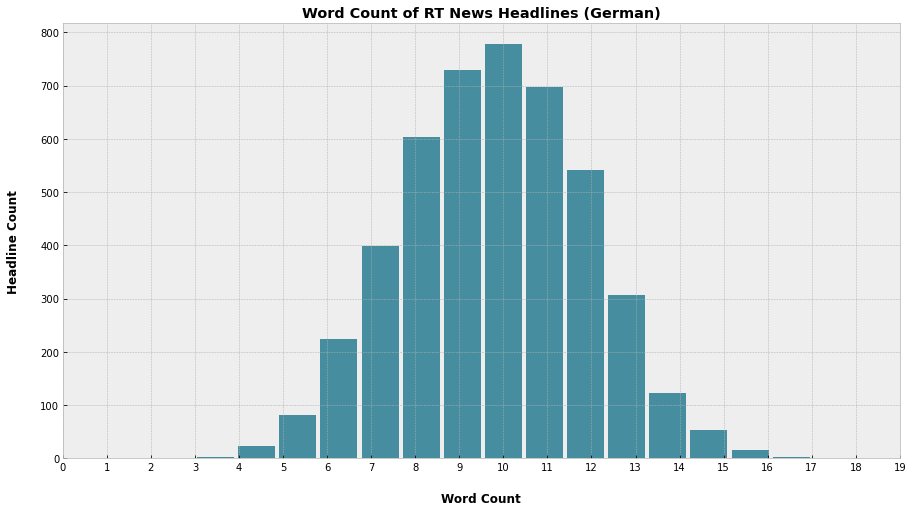

In [71]:
# Visualize word count of RT News Headlines for the year 2020

plt.style.use('bmh')

# data to be used
word_count = df_2020['Word Count']

# make plot
plt.hist(word_count, bins=15, rwidth=0.9, color = '#458D9F')
plt.gcf().set_size_inches(15, 8)

# labels, colors, axes
plt.title('Word Count of RT News Headlines (German)', fontweight='bold')
plt.xlabel('Word Count', fontweight='bold', labelpad=20)
plt.ylabel('Headline Count', fontweight='bold', labelpad=20)
plt.xlim(xmin=min(word_count), xmax = max(word_count))
plt.xticks(np.arange(0,20, step=1))
plt.show()

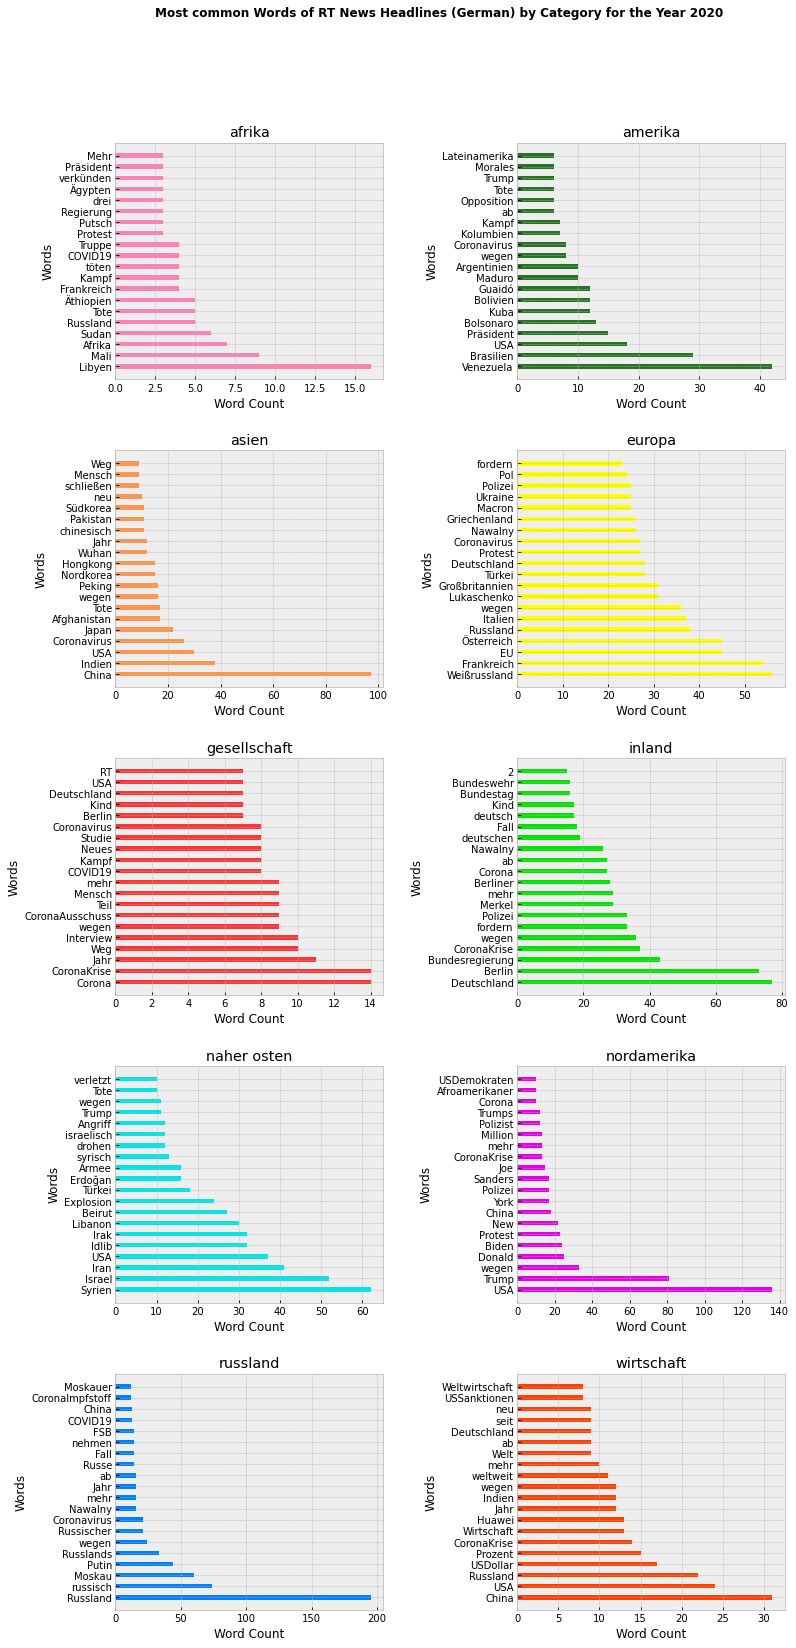

In [72]:
# Viualize: Bag-of-words by category for articles from the year 2020

# data
gesellschaft = bow_df[bow_df['Category'] == 'gesellschaft']
wirtschaft = bow_df[bow_df['Category'] == 'wirtschaft']
inland =  bow_df[bow_df['Category'] == 'inland']
asien =  bow_df[bow_df['Category'] == 'asien']
amerika =  bow_df[bow_df['Category'] == 'amerika']
nordamerika = bow_df[bow_df['Category'] == 'nordamerika']
europa =  bow_df[bow_df['Category'] == 'europa']
der_nahe_osten =  bow_df[bow_df['Category'] == 'naher osten']
afrika =  bow_df[bow_df['Category'] == 'afrika']
russland =  bow_df[bow_df['Category'] == 'russland']

# plot style + labels for subplots
plt.style.use('bmh')
labels = sorted([category for category in bow_df['Category'].unique()])

# make subplots
fig, axs = plt.subplots(5,2)
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
fig.suptitle('Most common Words of RT News Headlines (German) by Category for the Year 2020',
             fontweight='bold', y=0.95)
fig.set_figheight(27)
fig.set_figwidth(12)

axs[0, 0].barh(afrika['Most Common Word'], afrika['Word Count'], color = '#ff80b3', height=0.4)
axs[0, 1].barh(amerika['Most Common Word'], amerika['Word Count'], color = '#267326', height=0.4)
axs[1, 0].barh(asien['Most Common Word'], asien['Word Count'], color = '#ff944d', height=0.4)
axs[1, 1].barh(europa['Most Common Word'], europa['Word Count'],  color = '#ffff00', height=0.4)
axs[2, 0].barh(gesellschaft['Most Common Word'], gesellschaft['Word Count'], color = '#ff3333', height=0.4)
axs[2, 1].barh(inland['Most Common Word'], inland['Word Count'], color = '#00e600', height=0.4)
axs[3, 0].barh(der_nahe_osten['Most Common Word'], der_nahe_osten['Word Count'], color = '#00e6e6', height=0.4)
axs[3, 1].barh(nordamerika['Most Common Word'], nordamerika['Word Count'], color = '#e600e6', height=0.4)
axs[4, 0].barh(russland['Most Common Word'], russland['Word Count'], color = '#0080ff', height=0.4)
axs[4, 1].barh(wirtschaft['Most Common Word'], wirtschaft['Word Count'], color = '#ff4000', height=0.4)


# iterate over subplots and set sub-title, axes-labels, axes-limits
i = 0

for ax in axs.flat:
    # label
    ax.set(xlabel='Word Count', ylabel='Words')
    
    #limit
    ax.set_xlim(xmin=0)
    
    #subtitle
    current = labels[i]
    ax.set_title(current)
    i += 1
plt.show()

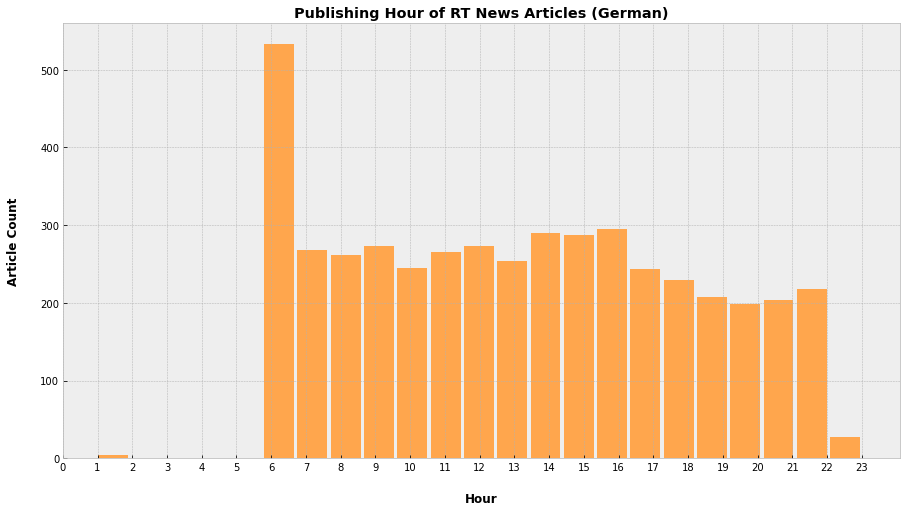

In [73]:
# Visualize: hour of publication 

plt.style.use('bmh')

# data to be used: subset only articles from 2020
hour = df_2020['Date'].dt.hour

# make plot
plt.hist(hour, bins=24, rwidth=0.9, color = '#ffa64d')
plt.gcf().set_size_inches(15, 8)

# labels, colors, axes
plt.title('Publishing Hour of RT News Articles (German)', fontweight='bold')
plt.xlabel('Hour', fontweight='bold', labelpad=20)
plt.ylabel('Article Count', fontweight='bold', labelpad=20)
plt.xticks(np.arange(0,24, step=1))
plt.xlim(xmin=0)

plt.show()

In [74]:
# rule-based sentiment analysis: Sentiment class uses sentiment dictionary

class Sentiment:
    def __init__(self, df_data):
        self.df_data = df_data
        
    def get_sentiment(self):
        
        doc = nlp2(self.df_data)
        
        # for counting sentiment per headline
        pos = 0
        neg = 0
        
        # iterate over tokens in headline and get sentiment score from sentiment dictionary
        for token in doc:
            sentiment = token._.sentiws
            
            # add sentiment to count
            try: 
                if sentiment < 0:
                    neg += 1
                if sentiment > 0:
                    pos += 1
            except TypeError as t:
                pass

        # calculate different sentiment scores
        net_sentiment = pos - neg # Breen's Approach: pos num_words - neg num_words
        
        ratio_pos = round(pos/len(self.df_data.split()),2) #ratio of positive words
        ratio_neg = round(neg/len(self.df_data.split()),2) #ratio of negative words
        
        return pd.Series([net_sentiment, ratio_pos, ratio_neg])
        
 
        

In [75]:
# apply class row-wise and store sentiment scores in 3 new columns
df_2020[['Net Sentiment','Ratio: pos', 'Ratio: neg']] = df_2020['Headline'].apply(lambda row: Sentiment(row).get_sentiment())

/home/tina/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [76]:
df_2020

,Headline,Date,category,Word Count,Article: No Stopwords,Lemmas,BoW,Net Sentiment,Ratio: pos,Ratio: neg
0,Ukrainischer Kleriker warnt vor den Schweinere...,2020-09-28 06:45:00,gesellschaft,8,"[Ukrainischer, Kleriker, warnt, Schweinereien,...","[Ukrainischer, Kleriker, warnen, Schweinerei, ...","{'Ukrainischer': 1, 'Kleriker': 1, 'warnen': 1...",0.0,0.00,0.00
1,Der MagnetKünstler Kleben und kleben lassen Video,2020-09-27 19:55:00,gesellschaft,7,"[MagnetKünstler, Kleben, kleben, lassen]","[MagnetKünstler, Kleben, kleben, lassen]","{'MagnetKünstler': 1, 'Kleben': 1, 'kleben': 1...",0.0,0.00,0.00
2,Es grünt Guccis GärtnerJeans mit Grasflecken f...,2020-09-26 16:55:00,gesellschaft,15,"[grünt, Guccis, GärtnerJeans, Grasflecken, kna...","[grünt, Guccis, GärtnerJeans, Grasflecken, kna...","{'grünt': 1, 'Guccis': 1, 'GärtnerJeans': 1, '...",0.0,0.00,0.00
3,Chef des Weltwirtschaftsforums Neoliberalismus...,2020-09-26 16:20:00,gesellschaft,8,"[Chef, Weltwirtschaftsforums, Neoliberalismus,...","[Chef, Weltwirtschaftsforums, Neoliberalismus,...","{'Chef': 1, 'Weltwirtschaftsforums': 1, 'Neoli...",0.0,0.00,0.00
4,Umstrittene Maßnahme Absichtliche CoronaInfekt...,2020-09-26 09:41:00,gesellschaft,9,"[Umstrittene, Maßnahme, Absichtliche, CoronaIn...","[Umstrittene, Maßnahme, Absichtliche, CoronaIn...","{'Umstrittene': 1, 'Maßnahme': 1, 'Absichtlich...",-1.0,0.00,0.11
...,...,...,...,...,...,...,...,...,...,...
8561,Nordmazedonien und Griechenland erhalten Gas a...,2020-01-07 06:30:00,wirtschaft,10,"[Nordmazedonien, Griechenland, erhalten, Gas, ...","[Nordmazedonien, Griechenland, erhalten, Gas, ...","{'Nordmazedonien': 1, 'Griechenland': 1, 'erha...",1.0,0.10,0.00
8562,Paris Finanzminister warnt USA vor Vergeltung ...,2020-01-06 09:52:00,wirtschaft,11,"[Paris, Finanzminister, warnt, USA, Vergeltung...","[Paris, Finanzminister, warnen, USA, Vergeltun...","{'Paris': 1, 'Finanzminister': 1, 'warnen': 1,...",-1.0,0.00,0.09
8563,USMordanschlag auf iranischen General setzt Fi...,2020-01-03 21:34:00,wirtschaft,8,"[USMordanschlag, iranischen, General, setzt, F...","[USMordanschlag, iranisch, General, setzen, Fi...","{'USMordanschlag': 1, 'iranisch': 1, 'General'...",0.0,0.00,0.00
8564,Indien wird Deutschland als viertgrößte Volksw...,2020-01-03 06:15:00,wirtschaft,11,"[Indien, Deutschland, viertgrößte, Volkswirtsc...","[Indien, Deutschland, viertgrößte, Volkswirtsc...","{'Indien': 1, 'Deutschland': 1, 'viertgrößte':...",1.0,0.09,0.00


In [77]:
# group df_2020 by category, get the mean scores for the sentiments every month
mean_scores = df_2020.groupby(['category', pd.Grouper(key='Date', freq='D')]).mean()


In [78]:
mean_scores

Word Count  Net Sentiment  Ratio: pos  Ratio: neg
category   Date                                                         
afrika     2020-01-01        10.0       0.000000        0.10    0.100000
           2020-01-05        11.0       0.000000        0.00    0.000000
           2020-01-06         9.0      -0.666667        0.03    0.103333
           2020-01-07         9.0       2.000000        0.22    0.000000
           2020-01-09        14.0      -2.000000        0.00    0.140000
...                           ...            ...         ...         ...
wirtschaft 2020-09-23        10.0       2.000000        0.20    0.000000
           2020-09-24        11.0       0.000000        0.00    0.000000
           2020-09-25         9.0      -2.000000        0.00    0.220000
           2020-09-26        10.0       0.000000        0.00    0.000000
           2020-09-28         9.0       0.000000        0.00    0.000000

[1830 rows x 4 columns]

In [79]:
# min-max normalization, so the mean sentiment scores are between 0 and 1
def get_norm(data_point, df_values):
    result = (data_point - df_values.min()) / ((df_values.max()) - df_values.min())
    return result

mean_scores['Normalized Scores'] = mean_scores['Net Sentiment'].apply(lambda row: get_norm(row, mean_scores['Net Sentiment'].values))


In [80]:
mean_scores

Word Count  Net Sentiment  Ratio: pos  Ratio: neg  \
category   Date                                                            
afrika     2020-01-01        10.0       0.000000        0.10    0.100000   
           2020-01-05        11.0       0.000000        0.00    0.000000   
           2020-01-06         9.0      -0.666667        0.03    0.103333   
           2020-01-07         9.0       2.000000        0.22    0.000000   
           2020-01-09        14.0      -2.000000        0.00    0.140000   
...                           ...            ...         ...         ...   
wirtschaft 2020-09-23        10.0       2.000000        0.20    0.000000   
           2020-09-24        11.0       0.000000        0.00    0.000000   
           2020-09-25         9.0      -2.000000        0.00    0.220000   
           2020-09-26        10.0       0.000000        0.00    0.000000   
           2020-09-28         9.0       0.000000        0.00    0.000000   

                       Normalized Scores  
category   Date                           
afrika     2020-01-01           0.428571  
           2020-01-05           0.428571  
           2020-01-06           0.333333  
           2020-01-07           0.714286  
           2020-01-09           0.142857  
...                                  ...  
wirtschaft 2020-09-23           0.714286  
           2020-09-24           0.428571  
           2020-09-25           0.142857  
           2020-09-26           0.428571  
           2020-09-28           0.428571  

[1830 rows x 5 columns]

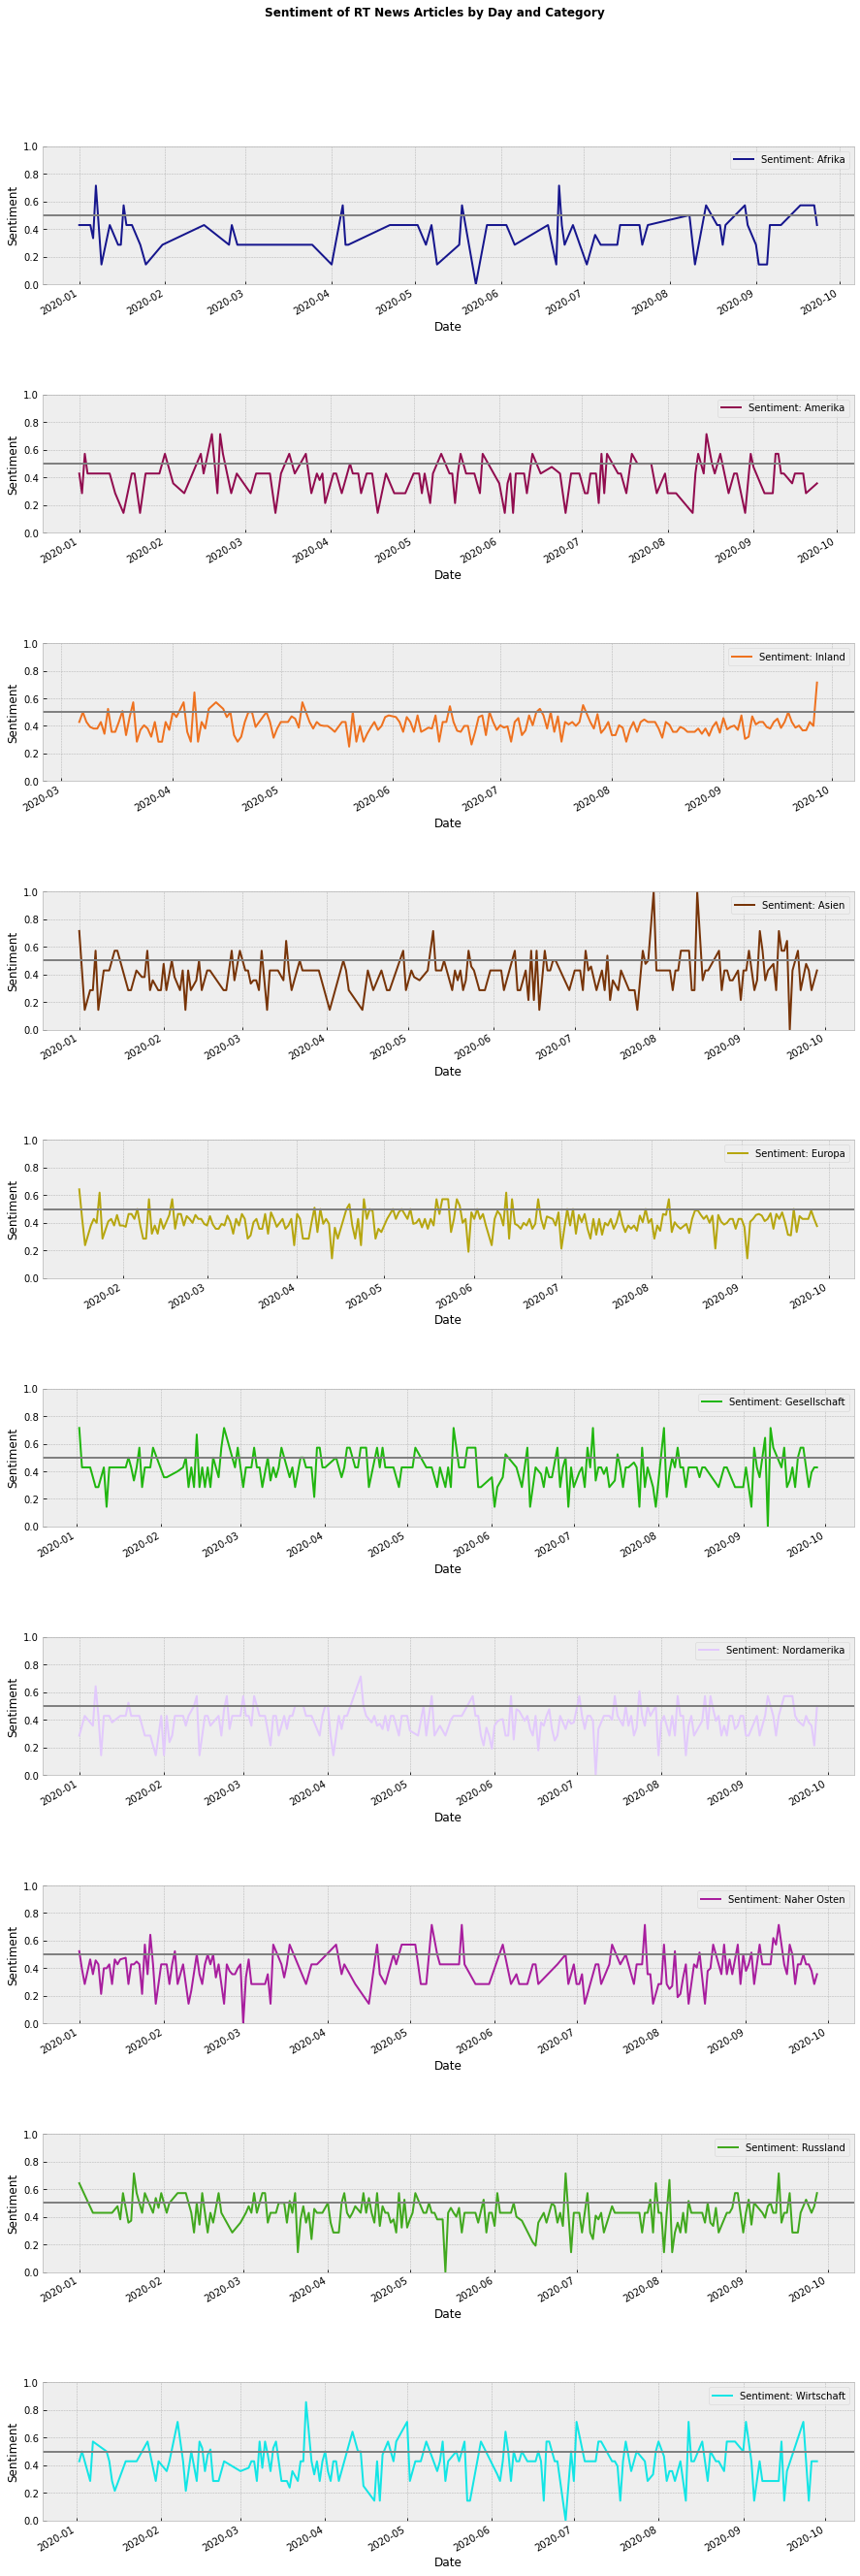

In [81]:
# Viszualize Sentiment changes throughout 2020
plt.style.use('bmh')
fig, a = plt.subplots(10,1)
plt.subplots_adjust(hspace = 0.8, wspace = 0.5)
fig.suptitle('Sentiment of RT News Articles by Day and Category',
             fontweight='bold', y=0.92)

fig.set_figheight(50)
fig.set_figwidth(15)


mean_scores.xs('afrika').plot(ax=a[0], y='Normalized Scores', 
                              label='Sentiment: Afrika', color='#16168D')
mean_scores.xs('amerika').plot(ax=a[1], y='Normalized Scores', 
                               label='Sentiment: Amerika', color='#910C4F')
mean_scores.xs('inland').plot(ax=a[2], y='Normalized Scores', 
                              label='Sentiment: Inland', color='#EE7220')
mean_scores.xs('asien').plot(ax=a[3], y='Normalized Scores', 
                             label='Sentiment: Asien', color='#773408')
mean_scores.xs('europa').plot(ax=a[4], y='Normalized Scores', 
                              label='Sentiment: Europa', color='#B6A60F')
mean_scores.xs('gesellschaft').plot(ax=a[5], y='Normalized Scores', 
                                    label='Sentiment: Gesellschaft', color='#20B60F')
mean_scores.xs('nordamerika').plot(ax=a[6], y='Normalized Scores', 
                                    label='Sentiment: Nordamerika', color='#E2C9FC')
mean_scores.xs('naher osten').plot(ax=a[7], y='Normalized Scores', 
                                    label='Sentiment: Naher Osten', color='#A81E9E')
mean_scores.xs('russland').plot(ax=a[8], y='Normalized Scores', 
                                    label='Sentiment: Russland', color='#41A81E')
mean_scores.xs('wirtschaft').plot(ax=a[9], y='Normalized Scores', 
                                    label='Sentiment: Wirtschaft', color='#13E5E5')


for ax in a.flat:
    # label
    ax.set(ylabel='Sentiment')
    
    #limit
    ax.set_ylim(ymin=mean_scores['Normalized Scores'].min(),ymax=mean_scores['Normalized Scores'].max())
    ax.axhline(0.5, color='grey')
   
plt.show()

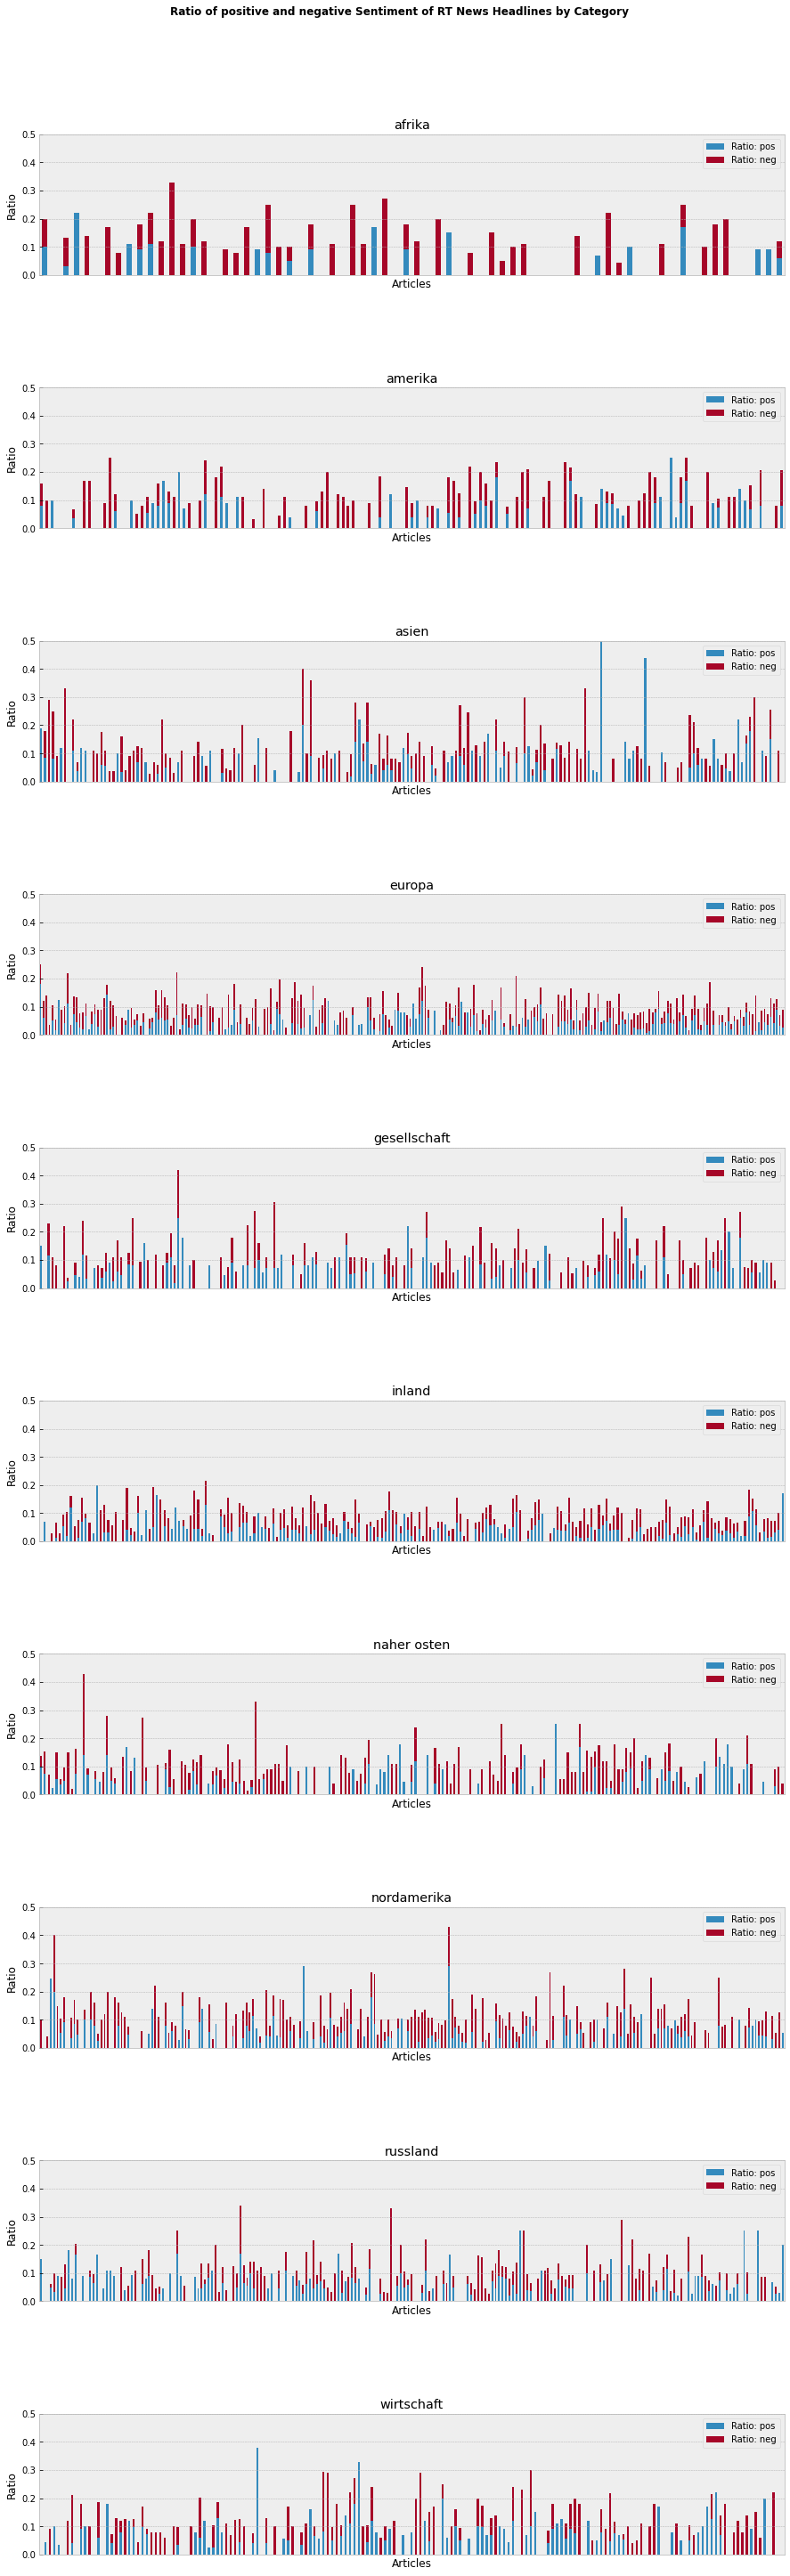

In [82]:
# Visualize ratio of positive and negative sentiment articles
plt.style.use('bmh')
fig, a = plt.subplots(10,1)
plt.subplots_adjust(hspace = 0.8, wspace = 0.5)
fig.suptitle('Ratio of positive and negative Sentiment of RT News Headlines by Category',
             fontweight='bold', y=0.92)

fig.set_figheight(50)
fig.set_figwidth(15)



mean_scores.xs('afrika')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[0])
mean_scores.xs('amerika')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[1])
mean_scores.xs('asien')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[2])
mean_scores.xs('europa')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[3])
mean_scores.xs('gesellschaft')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[4])
mean_scores.xs('inland')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[5])
mean_scores.xs('naher osten')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[6])
mean_scores.xs('nordamerika')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[7])
mean_scores.xs('russland')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[8])
mean_scores.xs('wirtschaft')[['Ratio: pos', 'Ratio: neg']].plot(kind='bar', stacked=True, ax=a[9])


# iterate over categories to set subtitles
labels = sorted([category for category in bow_df['Category'].unique()])
i = 0

for ax in a.flat:
                                                                
    # label
    ax.set(ylabel='Ratio')
    ax.set(xlabel='Articles')
    ax.set_xticks([])
    
    #limit
    ax.set_ylim(ymin=mean_scores['Ratio: neg'].min(),ymax=mean_scores['Ratio: pos'].max())
    
    #subtitle
    current = labels[i]
    ax.set_title(current)
    i += 1
   
plt.show()





In [83]:
# Topic modeling with LDA: create vocabulary of all the words in the data (document-term-matrix)
# ignore terms that appear too frequently (more than in 80% of the docs) + infrequently
count_vect = CountVectorizer(max_df=0.8, min_df=20, stop_words=german_stop_words)
doc_term_matrix = count_vect.fit_transform(df_2020['Headline'].values.astype('U'))


In [84]:
# create topics 
# along with the probability distribution for each word in our vocabulary for each topic
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [85]:
# find 10 words with the highest probability for the first topic

# array with probabilties
first_topic = LDA.components_[0] 

# sort according to prob. values:
# last 10 indexes of the array = 10 words with highest probability
top_topic_words = first_topic.argsort()[-10:] 
 

# retrieve value from count_vec object of the words belonging to topic 1
for i in top_topic_words:
   print(count_vect.get_feature_names()[i])
     

sanktionen
gibt
menschen
proteste
fall
weißrussland
nawalny
usa
coronavirus
video


In [86]:
topic_list = [] # list of lists with top 5 topics

# iterate over the five components, arrays
for component,topic in enumerate(LDA.components_):
    # get the last 10 words (= highest probability of appearance)
    topic = topic.argsort()[-10:]
    
    #make list of the words
    words =  [count_vect.get_feature_names()[component] for component in topic]
    topic_list.append(words)
print(topic_list)


[['sanktionen', 'gibt', 'menschen', 'proteste', 'fall', 'weißrussland', 'nawalny', 'usa', 'coronavirus', 'video'], ['geht', 'putin', 'droht', 'präsident', 'covid19', 'bundesregierung', 'prozent', 'ab', 'mehr', 'russland'], ['russische', 'syrien', 'frankreich', 'polizei', 'coronakrise', 'moskau', 'neue', 'berlin', 'trump', 'wegen'], ['großbritannien', 'kampf', 'immer', 'milliarden', 'euro', 'eu', 'iran', 'russlands', 'corona', 'deutschland'], ['jahre', 'jahren', 'seit', 'venezuela', 'deutsche', 'fordert', 'millionen', 'trotz', 'china', 'usa']]


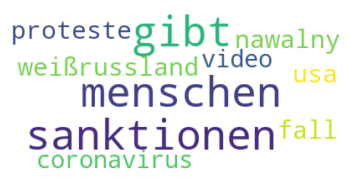

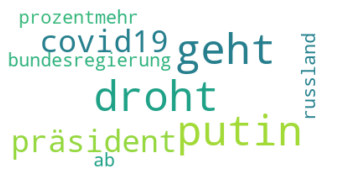

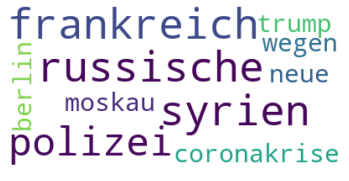

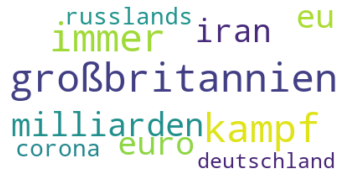

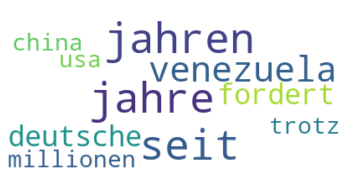

In [87]:
# Visualize top 5 topics 

for topic in topic_list:
    wordcloud = WordCloud(max_font_size=50, background_color="white").generate(' '.join(topic))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()